# Use Off-Policy VPG to Play CartPole-v0

TensorFlow version

In [1]:
%matplotlib inline

import sys
import logging
import itertools

import numpy as np
np.random.seed(0)
import pandas as pd
import gym
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
tf.random.set_seed(0)
from tensorflow import keras
from tensorflow import nn
from tensorflow import optimizers
from tensorflow.keras import layers
from tensorflow.keras import losses

logging.basicConfig(level=logging.INFO,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

In [2]:
env = gym.make('CartPole-v0')
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])
for key in vars(env.spec):
    logging.info('%s: %s', key, vars(env.spec)[key])

11:29:13 [INFO] env: <CartPoleEnv<CartPole-v0>>
11:29:13 [INFO] action_space: Discrete(2)
11:29:13 [INFO] observation_space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
11:29:13 [INFO] reward_range: (-inf, inf)
11:29:13 [INFO] metadata: {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 50}
11:29:13 [INFO] _max_episode_steps: 200
11:29:13 [INFO] _elapsed_steps: None
11:29:13 [INFO] id: CartPole-v0
11:29:13 [INFO] entry_point: gym.envs.classic_control:CartPoleEnv
11:29:13 [INFO] reward_threshold: 195.0
11:29:13 [INFO] nondeterministic: False
11:29:13 [INFO] max_episode_steps: 200
11:29:13 [INFO] _kwargs: {}
11:29:13 [INFO] _env_name: CartPole


In [3]:
class OffPolicyVPGAgent:
    def __init__(self, env):
        self.action_n = env.action_space.n
        self.gamma = 0.99

        def dot(y_true, y_pred):
            return -tf.reduce_sum(y_true * y_pred, axis=-1)

        self.policy_net = self.build_net(hidden_sizes=[],
                output_size=self.action_n,
                output_activation=nn.softmax,
                loss=dot, learning_rate=0.06)

    def build_net(self, hidden_sizes, output_size,
            activation=nn.relu, output_activation=None,
            use_bias=False, loss=losses.mse, learning_rate=0.001):
        model = keras.Sequential()
        for hidden_size in hidden_sizes:
            model.add(layers.Dense(units=hidden_size,
                    activation=activation, use_bias=use_bias))
        model.add(layers.Dense(units=output_size,
                activation=output_activation, use_bias=use_bias))
        optimizer = optimizers.Adam(learning_rate)
        model.compile(optimizer=optimizer, loss=loss)
        return model

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []

    def step(self, observation, reward, terminated):
        if self.mode == 'train':
            action = np.random.choice(self.action_n)  # use random policy
            self.trajectory += [observation, reward, terminated, action]
        else:
            probs = self.policy_net.predict(observation[np.newaxis], verbose=0)[0]
            action = np.random.choice(self.action_n, p=probs)
        return action

    def close(self):
        if self.mode == 'train':
            self.learn()

    def learn(self):
        df = pd.DataFrame(np.array(self.trajectory, dtype=object).reshape(-1, 4),
                columns=['state', 'reward', 'terminated', 'action'])
        df['discount'] = self.gamma ** df.index.to_series()
        df['discounted_reward'] = df['discount'] * df['reward'].astype(float)
        df['discounted_return'] = df['discounted_reward'][::-1].cumsum()
        states = np.stack(df['state'])
        actions = np.eye(self.action_n)[df['action'].astype(int)]
        df['behavior_prob'] = 1. / self.action_n
        df['sample_weight'] = df['discounted_return'] / df['behavior_prob']
        sample_weight = df[['sample_weight',]].values
        self.policy_net.fit(states, actions, sample_weight=sample_weight,
                verbose=0)


agent = OffPolicyVPGAgent(env)

11:29:14 [INFO] ==== train ====
11:29:15 [INFO] NumExpr defaulting to 4 threads.
11:29:20 [INFO] train episode 0: reward = 34.00, steps = 34
11:29:21 [INFO] train episode 1: reward = 16.00, steps = 16
11:29:22 [INFO] train episode 2: reward = 20.00, steps = 20
11:29:23 [INFO] train episode 3: reward = 17.00, steps = 17
11:29:25 [INFO] train episode 4: reward = 26.00, steps = 26
11:29:25 [INFO] train episode 5: reward = 12.00, steps = 12
11:29:27 [INFO] train episode 6: reward = 25.00, steps = 25
11:29:28 [INFO] train episode 7: reward = 19.00, steps = 19
11:29:30 [INFO] train episode 8: reward = 37.00, steps = 37
11:29:31 [INFO] train episode 9: reward = 27.00, steps = 27
11:29:32 [INFO] train episode 10: reward = 16.00, steps = 16
11:29:33 [INFO] train episode 11: reward = 23.00, steps = 23
11:29:34 [INFO] train episode 12: reward = 12.00, steps = 12
11:29:35 [INFO] train episode 13: reward = 24.00, steps = 24
11:29:36 [INFO] train episode 14: reward = 10.00, steps = 10
11:29:37 [INFO

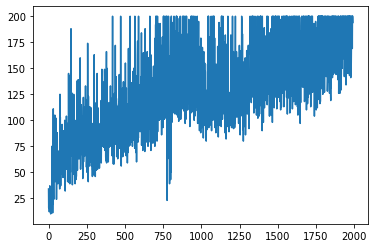

In [4]:
def play_episode(env, agent, seed=None, mode=None, render=False):
    observation, _ = env.reset(seed=seed)
    reward, terminated, truncated = 0., False, False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, terminated)
        if render:
            env.render()
        if terminated or truncated:
            break
        observation, reward, terminated, truncated, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    play_episode(env, agent, seed=episode,
            mode='train')
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.info('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-10:]) > 195:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.info('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

In [5]:
env.close()